In [ ]:
# pip install requests

  Using cached requests-2.32.3-py3-none-any.whl (64 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.5/149.5 KB 938.1 kB/s eta 0:00:00a 0:00:01
  Using cached urllib3-2.4.0-py3-none-any.whl (128 kB)
Note: you may need to restart the kernel to use updated packages.


In [1]:
from pandas import read_sql_query, read_sql_table

import pandas as pd
import sqlite3
from matplotlib import pyplot as plt
import datetime

import requests
import json

In [2]:
# postgres

host = "localhost"
port = "5432"  # default port for PostgreSQL
user = "postgres"  # replace with your PostgreSQL username
password = "1374fjsney831"  # replace with your password
dbname = "mexc_statistics_case"

In [7]:
# pip install psycopg2-binary

  Using cached psycopg2_binary-2.9.10-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (3.0 MB)
Note: you may need to restart the kernel to use updated packages.


In [4]:
import psycopg2
import pandas as pd

# Подключение к первой базе
conn1 = psycopg2.connect(
    dbname=dbname,
    user=user,
    password=password,
    host=host,
    port=port
)


In [6]:
# add utulity

import psycopg2
from datetime import datetime, timedelta

DB = dict(
    dbname="mexc_statistics_case",
    user="postgres",
    password="1374fjsney831",
    host="localhost",
    port=5432,
)


# ---------- low‑level helpers ----------
def _connect():
    return psycopg2.connect(**DB)


def create_pump_event_stats_table():
    ddl_table = """
    CREATE TABLE IF NOT EXISTS pump_event_stats (
        id            SERIAL PRIMARY KEY,
        coin_symbol   TEXT NOT NULL
                      REFERENCES coins(coin) ON DELETE CASCADE,
        pump_start_ts BIGINT  NOT NULL,
        pump_end_ts   BIGINT,
        duration_sec  INTEGER,
        diff_percent  NUMERIC(8,3),
        bucket        VARCHAR(20),
        is_profit     BOOLEAN,
        created_at    TIMESTAMPTZ DEFAULT NOW(),
        UNIQUE (coin_symbol, pump_start_ts)
    );
    """

    ddl_index = """
    CREATE INDEX IF NOT EXISTS idx_pes_coin_time
        ON pump_event_stats (coin_symbol, pump_start_ts);
    """

    with _connect() as conn:
        conn.autocommit = True        # чтобы DDL сразу фиксировалась
        with conn.cursor() as cur:
            cur.execute(ddl_table)    # 1️⃣ создаём таблицу
            cur.execute(ddl_index)    # 2️⃣ создаём индекс
    print("✅ pump_event_stats готова")


def save_event_stat(
        coin_symbol: str,
        pump_start_ts: int,
        pump_end_ts: int | None,
        diff_percent: float | None,
        bucket: str,
        is_profit: bool | None):
    duration = (pump_end_ts - pump_start_ts) if pump_end_ts else None
    sql = """
    INSERT INTO pump_event_stats
          (coin_symbol, pump_start_ts, pump_end_ts,
           duration_sec, diff_percent, bucket, is_profit)
    VALUES (%s, %s, %s, %s, %s, %s, %s)
    ON CONFLICT (coin_symbol, pump_start_ts)
        DO UPDATE SET
            pump_end_ts   = EXCLUDED.pump_end_ts,
            duration_sec  = EXCLUDED.duration_sec,
            diff_percent  = EXCLUDED.diff_percent,
            bucket        = EXCLUDED.bucket,
            is_profit     = EXCLUDED.is_profit;
    """
    with _connect() as conn, conn.cursor() as cur:
        cur.execute(sql, (
            coin_symbol,
            pump_start_ts,
            pump_end_ts,
            duration,
            diff_percent,
            bucket,
            is_profit
        ))

def load_stats_last_3_days(coin_symbol: str):
    """Возвращает агрегированную сводку за 72 ч для переданной монеты."""
    three_days_ago = int((datetime.utcnow() - timedelta(days=3)).timestamp())
    query = """
    SELECT
        COUNT(*)                           AS deals_total,
        COUNT(*) FILTER (WHERE is_profit)  AS wins,
        COUNT(*) FILTER (WHERE NOT is_profit) AS losses,
        ROUND(SUM(diff_percent) FILTER (WHERE is_profit), 2)  AS sum_profit_pct,
        ROUND(SUM(diff_percent) FILTER (WHERE NOT is_profit), 2) AS sum_loss_pct
    FROM pump_event_stats
    WHERE coin_symbol = %s
      AND pump_start_ts >= %s;
    """
    with _connect() as conn, conn.cursor() as cur:
        cur.execute(query, (coin_symbol, three_days_ago))
        cols = [c.name for c in cur.description]
        row = cur.fetchone()
    return dict(zip(cols, row))


In [7]:
with _connect() as conn, conn.cursor() as cur:
    cur.execute("""
        SELECT column_name, data_type, is_nullable
        FROM information_schema.columns
        WHERE table_name = 'coins';
    """)
    for col in cur.fetchall():
        print(col)


('isnew', 'boolean', 'YES')
('coin', 'character varying', 'YES')
('maxleverage', 'character varying', 'YES')
('limitmaxvol', 'character varying', 'YES')
('amount24', 'character varying', 'YES')
('fundingrate', 'character varying', 'YES')


In [8]:
# # laucn only one time locally
create_pump_event_stats_table()   # должно вывести галочку

# убедимся:
with _connect() as c, c.cursor() as cur:
    cur.execute("SELECT to_regclass('pump_event_stats');")
    print("Найдена таблица:", cur.fetchone()[0])

✅ pump_event_stats готова
Найдена таблица: pump_event_stats


In [14]:
# Старая функция чтения базы

def read_sqlite(dbfile):
    with sqlite3.connect(dbfile) as dbcon:
        tables = list(read_sql_query("SELECT name FROM sqlite_master WHERE type='table';", dbcon)['name'])
        out = {tbl : read_sql_query(f"SELECT * from {tbl}", dbcon) for tbl in tables}
    
    return out

def add_time_to_df(df, time_colname='time'):
    for i, row in df.iterrows():
        df['dt'] = df[time_colname].apply(lambda x: datetime.fromtimestamp(x))
        return df

In [15]:
def get_xy_from_db(token, db_fp = 'bd.sqlite'):
    sql_data = read_sqlite(db_fp)
    
    d = sql_data['futures']
    d = add_time_to_df(d, time_colname='time')
    d_filetered = d[d['coin']==token]

    x = d_filetered['dt']
    y = d_filetered['mean']
    
    return x, y

def get_xy_from_api(token, start, end):
    # Alternative:
    req = f'https://futures.mexc.com/api/v1/contract/kline/{token}?end={end}&interval=Min15&start={start}'
    # req = 'https://futures.mexc.com/api/v1/contract/detail'
    answer = requests.get(req)
    data = json.loads(answer.text)['data']
    df = pd.DataFrame(data)
    df = add_time_to_df(df)
    return df['dt'], df['open']

In [17]:
token = 'AIL_USDT'

##### POINTS DATA
db_fp = 'db.sqlite3'
sql_data = read_sqlite(db_fp)

p = sql_data['monitoring_app_tradingpair']

coin_id = p[p['symbol']==token].id.tolist()[0]  # 

k = sql_data['monitoring_app_event']
g = add_time_to_df(k, time_colname='event_time')
c = g[g['trading_pair_id']==coin_id]

if not c.shape[0]:
    print("Data not exist")
else:
    pstarts = c[c['event_type']=='pump_start'].sort_values(by='event_time').reset_index()
    pends = c[c['event_type']=='pump_end'].sort_values(by='event_time').reset_index()
    
    start, end = (int(pstarts.iloc[0]['event_time']), int(pends.iloc[-1]['event_time'])) #  int(datetime.datetime.now().timestamp()))
    
    ##### MINUTE DATA
    
    # x,y = get_xy_from_db(token, start, end)
    x,y = get_xy_from_api(token, start, end)

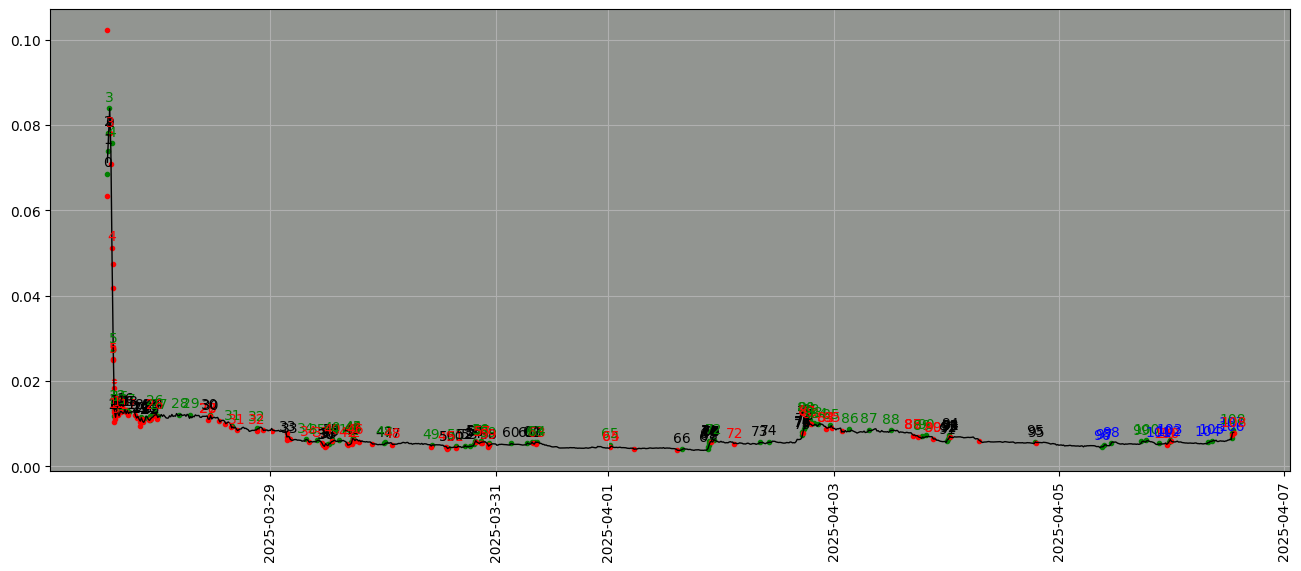

In [18]:
plt.figure(figsize=(16,6))
ax = plt.gca()
ax.set_facecolor('xkcd:gray')

x1, y1 = (pstarts['dt'], pstarts['event_price'])
x2, y2 = (pends['dt'], pends['event_price'])

plt.scatter(x1, y1, color='g', marker='.')
plt.scatter(x2, y2, color='r', marker='.')
# plt.plot(df['dt'], df['open'], color='black', linewidth=1)
plt.plot(x, y, color='black', linewidth=1)


# now = time.time()
fifteen_minutes_ago = 15 * 60
three_hours_ago = 3 * 3600
one_day_ago = 24 * 3600

pump_starts = pstarts
pump_ends = pends
# pair = await get_or_create_trading_pair(symbol)
# pump_starts = await get_pump_starts(pair)
# pump_ends = await get_pump_ends(pair)

now = pends.iloc[-1].event_time
cur_price = pends.iloc[-1].event_price
cur_i = 0

stats = {
    "fifteen_minutes": 0,
    "three_hours": 0,
    "one_day": 0,
    "more_one_day": 0,

    "profit_deals_cnt": 0,   # int: кол-во сделок в плюс
    "loss_deals_cnt": 0,     # int: кол-во сделок в минус
    "profit_percentage": 0,  # float: накопление профита в % чистого движения
    "loss_percentage": 0,    # float: накопление лосса в % чистого движения
    "in_deal_cnt": 0,        # int: кол-во сделок в отработке
    "in_deal_percentage": 0, # int: баланс сделки в отработке
}

for psi, pstart in pump_starts.iterrows():
    is_positive_deal = True
    diff_percent = 0
    next_pend = None
    non_closed = False
    loss_day_closed_price = 0
    for pei, pend in pump_ends.iterrows():
        if pend.event_time > pstart.event_time:
            # check if price lower thr
            if pend.event_price <= pstart.event_price*0.93:
                next_pend = pend
                break
            # check if price higher thr and got more one day
            elif now - pend.event_time >= one_day_ago:
                loss_day_closed_price = pend.event_price
                break
    # got win deal or got more one day loss deal
    if next_pend is not None:
        # deals emulation stats
        diff_percent = round((next_pend.event_price - pstart.event_price) / pstart.event_price * 100, 1)
        # timing stats
        if next_pend.event_time - pstart.event_time >= one_day_ago:
            stats["more_one_day"] += 1
            is_positive_deal = False
        elif next_pend.event_time - pstart.event_time >= three_hours_ago:
            stats["one_day"] += 1
        elif next_pend.event_time - pstart.event_time >= fifteen_minutes_ago:
            stats["three_hours"] += 1
        elif next_pend.event_time - pstart.event_time < fifteen_minutes_ago:
            stats["fifteen_minutes"] += 1
    # got current deal or current deal lasts more one day
    else:
        #  loss deal (lasts more one day and closed in minus for damp price)
        if loss_day_closed_price:
            is_positive_deal = False
            diff_percent = round((loss_day_closed_price - pstart.event_price) / pstart.event_price * 100, 1)
            stats["more_one_day"] += 1
        # deal lasts less one day and not closed
        else:
            non_closed = True
            # calculate difference of current price
            diff_percent = round((cur_price - pstart.event_price) / pstart.event_price * 100, 1)
            # adjust relevant value of percentage
            stats["in_deal_cnt"] += 1
            # pump loss deal
    if non_closed:
        stats["in_deal_percentage"] += diff_percent
        plt.annotate(cur_i, (x1[psi], y1[psi]), textcoords="offset points", xytext=(0, 5), ha='center', color='b')
    # profit deal
    elif is_positive_deal:

        plt.annotate(cur_i, (x1[psi], y1[psi]), textcoords="offset points", xytext=(0, 5), ha='center', color='g')
        plt.annotate(cur_i, (x2[pei], y2[pei]), textcoords="offset points", xytext=(0, 5), ha='center', color='r')
        
        stats['profit_deals_cnt'] += 1
        stats['profit_percentage'] += abs(diff_percent)
    # loss deal (lasts more one)
    elif not is_positive_deal:
        plt.annotate(cur_i, (x1[psi], y1[psi]), textcoords="offset points", xytext=(0, 5), ha='center', color='black')
        plt.annotate(cur_i, (x2[pei], y2[pei]), textcoords="offset points", xytext=(0, 5), ha='center', color='black')
        stats['loss_deals_cnt'] += 1
        stats['loss_percentage'] += abs(diff_percent)
    cur_i +=1

plt.xticks(rotation=90)
plt.grid()
plt.show()

In [19]:
# add new block

# ─────────────────── 0. Импорты и настройки ───────────────────
import sqlite3, psycopg2, requests, json, datetime, pandas as pd, matplotlib.pyplot as plt
from pandas import read_sql_query
from datetime import datetime, timedelta

DB = dict(dbname="mexc_statistics_case",
          user="postgres",
          password="1374fjsney831",
          host="localhost",
          port=5432)

TOKEN   = "AIL_USDT"        # монета, с которой тестируем
SQLITE  = "db.sqlite3"      # твой локальный дамп событий

# ─────────────────── 1. Postgre‑helpers ───────────────────
def _connect(): return psycopg2.connect(**DB)

# def create_pump_event_stats_table(): …                       # ← наш DDL (уже в коде)

# def save_event_stat(coin_symbol, pump_start_ts, pump_end_ts,
#                     diff_percent, bucket, is_profit): …      # ← из кода выше

# def load_stats_last_3_days(coin_symbol): …                   # ← из кода выше


# ─────────────────── 2. Утилиты чтения исходных данных ───────────────────
def read_sqlite(dbfile):
    with sqlite3.connect(dbfile) as dbcon:
        names = read_sql_query(
            "SELECT name FROM sqlite_master WHERE type='table';", dbcon)['name']
        return {t: read_sql_query(f"SELECT * FROM {t}", dbcon) for t in names}

def add_dt(df, time_col="time"):
    df["dt"] = pd.to_datetime(df[time_col], unit="s")
    return df

def klines_from_api(symbol, ts_start, ts_end):
    url = f"https://futures.mexc.com/api/v1/contract/kline/{symbol}?" \
          f"end={ts_end}&interval=Min15&start={ts_start}"
    data = requests.get(url).json()["data"]
    return add_dt(pd.DataFrame(data)), "open"


# ─────────────────── 3. Главный расчёт + запись в Postgre ───────────────────
def process_token(token: str):
    """Берём события пампа из sqlite, считаем diff, сохраняем построчно в Postgres."""
    src   = read_sqlite(SQLITE) # NOTE беррем данные из sqlite а надо из postgres 

    tp    = src["monitoring_app_tradingpair"]
    coin_id = tp[tp.symbol == token].id.iloc[0]

    ev    = add_dt(src["monitoring_app_event"], "event_time")
    ev    = ev[ev.trading_pair_id == coin_id]

    if ev.empty:
        print("Нет событий для", token); return

    starts = ev[ev.event_type == "pump_start"].sort_values("event_time").reset_index(drop=True)
    ends   = ev[ev.event_type == "pump_end"  ].sort_values("event_time").reset_index(drop=True)

    # минутные свечи — пригодятся для графика
    ts0, ts1 = int(starts.iloc[0].event_time), int(ends.iloc[-1].event_time)
    kl_df, price_col = klines_from_api(token, ts0, ts1)

    # ───────── цикл по каждому start ─────────
    for i, pstart in starts.iterrows():
        next_pend, loss_price, bucket, is_profit = None, None, "in_deal", None

        for _, pend in ends.iterrows():
            if pend.event_time <= pstart.event_time: continue    # конец раньше старта — пропускаем

            if pend.event_price <= pstart.event_price * 0.93:    # «вернулась на -7 %»
                next_pend  = pend;  bucket = "fifteen_minutes";  is_profit = True
                break
            if pend.event_time - pstart.event_time >= 86_400:    # > суток, считаем лосс
                loss_price = pend.event_price; bucket = "more_one_day"; is_profit = False
                break

        # diff % и конечное время
        end_ts, diff = None, None
        if next_pend is not None:
            end_ts = int(next_pend.event_time)
            diff   = round((next_pend.event_price - pstart.event_price) / pstart.event_price * 100, 3)
        elif loss_price:
            end_ts = int(pstart.event_time + 86_400)
            diff   = round((loss_price - pstart.event_price) / pstart.event_price * 100, 3)

        # запись в Postgre
        save_event_stat(
            coin_symbol   = token,
            pump_start_ts = int(pstart.event_time),
            pump_end_ts   = end_ts,
            diff_percent  = diff,
            bucket        = bucket,
            is_profit     = is_profit
        )

    print(f"✔ {token}: вставка завершена")


# ─────────────────── 4. Визуальная проверка и сводка ───────────────────
def plot_token(token: str):
    src = read_sqlite(SQLITE)
    ev  = add_dt(src["monitoring_app_event"], "event_time")
    coin_id = src["monitoring_app_tradingpair"][src["monitoring_app_tradingpair"].symbol == token].id.iloc[0]
    ev  = ev[ev.trading_pair_id == coin_id]

    starts = ev[ev.event_type == "pump_start"]
    ends   = ev[ev.event_type == "pump_end"]

    ts0, ts1 = int(starts.event_time.min()), int(ends.event_time.max())
    kl_df, price_col = klines_from_api(token, ts0, ts1)

    plt.figure(figsize=(14,5)); plt.plot(kl_df.dt, kl_df[price_col], lw=.7, label="price")
    plt.scatter(starts.dt, starts.event_price,  c="g", label="start")
    plt.scatter(ends.dt,   ends.event_price,    c="r", label="end")
    plt.title(token); plt.legend(); plt.grid(); plt.show()



✔ AIL_USDT: вставка завершена
{'deals_total': 0, 'wins': 0, 'losses': 0, 'sum_profit_pct': None, 'sum_loss_pct': None}


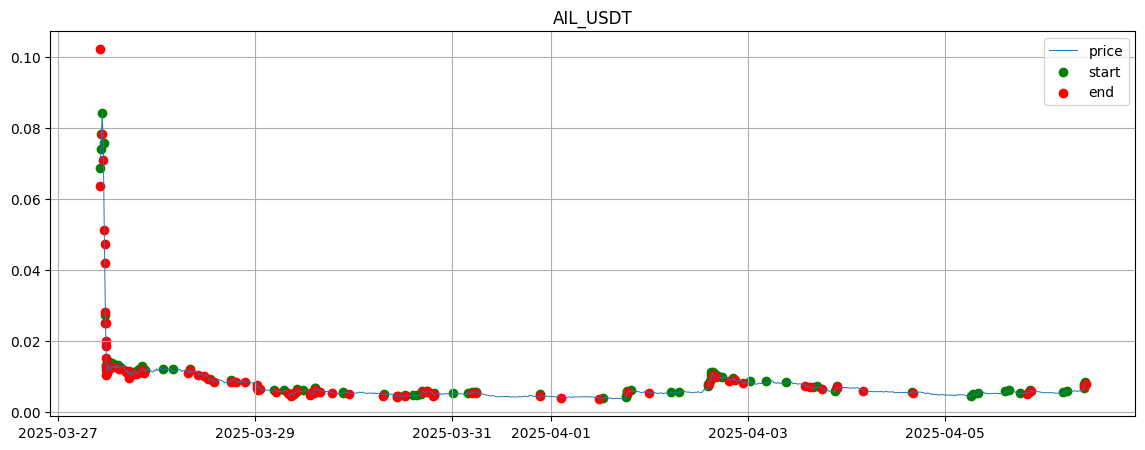

In [24]:

# ─────────────────── 5. Запуск end‑to‑end ───────────────────
# create_pump_event_stats_table()   # запускаем ровно один раз
process_token(TOKEN)              # кладёт строки в Postgres
print(load_stats_last_3_days(TOKEN))
plot_token(TOKEN)                 # рисуем график


In [ ]:
# add new block

In [23]:
"""
====================================================================
Pump‑stats demo — чистый Python код + минимальные pytest‑тесты
--------------------------------------------------------------------
Содержит два «виртуальных» файла в одном полотне:
  1. pump_stats.py       ⟶ основная логика + CLI
  2. test_pump_stats.py  ⟶ юнит‑тесты (pytest)

Скопируй нужные куски в отдельные .py‑файлы или просто запусти pytest
в текущей директории.
====================================================================
"""

# ──────────────────────────────────────────────────────────────────
#  pump_stats.py  (Library + CLI demo)
# ──────────────────────────────────────────────────────────────────

import time, requests, psycopg2, logging
from datetime import datetime, timedelta, timezone
from typing import Optional, Tuple, Dict, List, Callable

logging.basicConfig(
    level=logging.INFO,
    format="[%(asctime)s] %(levelname)s: %(message)s",
    datefmt="%H:%M:%S",
)
logger = logging.getLogger(__name__)

# === 1.  CONFIGURATION  =====================================================

DB: Dict[str, str | int] = {
    "dbname": "mexc_statistics_case",
    "user": "postgres",
    "password": "1374fjsney831",
    "host": "localhost",
    "port": 5432,
}

SYMBOL: str = "ALPACA_USDT"     # default coin
PUMP_THR: float = 1.07           # +7 % => pump start
CHECK_INTSEC: int = 15 * 60      # polling interval (15 min)

# === 2.  DATABASE HELPERS  ==================================================

def _pg():
    """Return fresh psycopg2 connection (autocommit ON)."""
    conn = psycopg2.connect(**DB)
    conn.autocommit = True
    return conn


def init_table() -> None:
    """Create pump_event_stats if it doesn't exist."""
    ddl = """
    CREATE TABLE IF NOT EXISTS pump_event_stats (
        id            SERIAL PRIMARY KEY,
        coin_symbol   TEXT NOT NULL REFERENCES coins(coin) ON DELETE CASCADE,
        pump_start_ts BIGINT NOT NULL,
        pump_end_ts   BIGINT,
        duration_sec  INTEGER,
        diff_percent  NUMERIC(8,3),
        bucket        VARCHAR(20),
        is_profit     BOOLEAN,
        UNIQUE (coin_symbol, pump_start_ts)
    );"""
    with _pg() as conn, conn.cursor() as cur:
        cur.execute(ddl)
    logger.info("table pump_event_stats OK")


def upsert_stat(
    symbol: str,
    ts_start: int,
    ts_end: Optional[int],
    diff_pct: Optional[float],
    bucket: str,
    is_profit: Optional[bool],
) -> None:
    """Insert / update single pump record."""
    duration = ts_end - ts_start if ts_end else None
    sql = """
    INSERT INTO pump_event_stats
          (coin_symbol, pump_start_ts, pump_end_ts,
           duration_sec, diff_percent, bucket, is_profit)
    VALUES (%s,%s,%s,%s,%s,%s,%s)
    ON CONFLICT (coin_symbol, pump_start_ts)
        DO UPDATE SET
            pump_end_ts   = EXCLUDED.pump_end_ts,
            duration_sec  = EXCLUDED.duration_sec,
            diff_percent  = EXCLUDED.diff_percent,
            bucket        = EXCLUDED.bucket,
            is_profit     = EXCLUDED.is_profit;"""
    with _pg() as conn, conn.cursor() as cur:
        cur.execute(sql, (symbol, ts_start, ts_end, duration,
                          diff_pct, bucket, is_profit))


def stats_last72h(symbol: str) -> Dict[str, int | float]:
    """Bucket counters + W/L + P/L for the last 72 h."""
    t0 = int((datetime.now(timezone.utc) - timedelta(days=3)).timestamp())
    sql = """
    WITH s AS (
        SELECT * FROM pump_event_stats
        WHERE coin_symbol=%s AND pump_start_ts >= %s
    )
    SELECT
        SUM((bucket='fifteen_minutes')::int) AS fifteen,
        SUM((bucket='three_hours')::int)     AS three_h,
        SUM((bucket='one_day')::int)         AS one_d,
        SUM((bucket='more_one_day')::int)    AS more_d,
        SUM((bucket='in_deal')::int)         AS in_deal,
        COUNT(*)                             AS total,
        SUM((is_profit IS TRUE)::int)        AS wins,
        SUM((is_profit IS FALSE)::int)       AS losses,
        ROUND(COALESCE(SUM(diff_percent)
              FILTER (WHERE is_profit),0),2) AS sum_profit_pct,
        ROUND(COALESCE(SUM(diff_percent)
              FILTER (WHERE is_profit IS FALSE),0),2) AS sum_loss_pct
    FROM s;"""
    with _pg() as conn, conn.cursor() as cur:
        cur.execute(sql, (symbol, t0))
        return dict(zip([d.name for d in cur.description], cur.fetchone()))

# === 3.  MEXC API  ===========================================================

def last_candle(symbol: str, session: Callable[..., requests.Response] = requests.get) \
        -> Optional[Tuple[int, float]]:
    """Return epoch‑second + open‑price of last 15‑min candle or None."""
    now_ms = int(time.time() * 1000)
    url = (f"https://futures.mexc.com/api/v1/contract/kline/{symbol}"
           f"?interval=Min15&start={now_ms-15*60*1000}&end={now_ms}")
    try:
        resp = session(url, timeout=10)
        resp.raise_for_status()
        j = resp.json()
        if not j.get("success", True):
            logger.warning("MEXC error: %s", j.get("msg", j.get("code")))
            return None
        candles = j.get("data") or []
        if not candles:
            logger.warning("empty candles list")
            return None
        ts_open_sec = int(candles[-1][0] / 1000)
        price_open  = float(candles[-1][1])
        return ts_open_sec, price_open
    except Exception as exc:  # network / json / ValueError
        logger.warning("network/json error: %s", exc)
        return None

# === 4.  PumpWatcher =========================================================

class PumpWatcher:
    """Detect pump starts/ends and log to DB (stateless external)."""

    def __init__(self, symbol: str,
                 pump_thr: float = PUMP_THR,
                 api_fn: Callable[[str], Optional[Tuple[int, float]]] = last_candle):
        self.symbol = symbol
        self.pump_thr = pump_thr
        self.api_fn = api_fn
        self.history: List[Tuple[int, float]] = []  # (ts, price)
        self.open_pumps: Dict[int, float] = {}      # ts_start -> price_start

    # ───────── helpers ─────────
    @staticmethod
    def _bucket(age: int) -> str:
        if age < 900:
            return "fifteen_minutes"
        if age < 3 * 3600:
            return "three_hours"
        if age < 24 * 3600:
            return "one_day"
        return "more_one_day"

    # ───────── main step ─────────
    def step(self) -> None:
        candle = self.api_fn(self.symbol)
        if candle is None:
            return
        ts, price = candle
        self.history.append((ts, price))

        # 1) open pump?
        ts_3h = ts - 3 * 3600
        base_price = next((p for (t, p) in reversed(self.history) if t <= ts_3h), None)
        if base_price and price >= base_price * self.pump_thr:
            if ts not in self.open_pumps:
                self.open_pumps[ts] = price
                logger.info("🚀 START %s price=%s", datetime.utcfromtimestamp(ts), price)
                upsert_stat(self.symbol, ts, None, None, "in_deal", None)

        # 2) close pumps?
        to_close = []
        for ts_start, p_start in self.open_pumps.items():
            age = ts - ts_start
            if price <= p_start * 0.93:  # profit
                bucket = self._bucket(age)
                diff = round((price - p_start) / p_start * 100, 3)
                upsert_stat(self.symbol, ts_start, ts, diff, bucket, True)
                logger.info("✅ PROFIT close %dm diff=%s%%", age // 60, diff)
                to_close.append(ts_start)
            elif age > 24 * 3600:        # loss (time)
                diff = round((price - p_start) / p_start * 100, 3)
                upsert_stat(self.symbol, ts_start, ts, diff, "more_one_day", False)
                logger.info("❌ LOSS close >24h diff=%s%%", diff)
                to_close.append(ts_start)
        for t in to_close:
            del self.open_pumps[t]

# === 5.  CLI DEMO  ===========================================================

def main_loop():
    init_table()
    watcher = PumpWatcher(SYMBOL)
    try:
        while True:
            watcher.step()
            if int(time.time()) % 3600 < CHECK_INTSEC:
                s = stats_last72h(SYMBOL)
                wr = round(100 * s['wins'] / s['total'], 1) if s['total'] else 0
                logger.info("72h: 15m=%s 3h=%s 24h=%s >24h=%s open=%s WR=%s%%",
                            s['fifteen'], s['three_h'], s['one_d'],
                            s['more_d'], s['in_deal'], wr)
            time.sleep(CHECK_INTSEC)
    except KeyboardInterrupt:
        logger.info("stopped by user")

# Entry point guard -----------------------------------------------------------
if __name__ == "__main__":
    main_loop()

# ──────────────────────────────────────────────────────────────────
#  test_pump_stats.py  (pytest unit tests)
# ──────────────────────────────────────────────────────────────────


[00:37:44] INFO: table pump_event_stats OK


[00:37:45] WARNING: network/json error: -1
[00:40:12] INFO: stopped by user
